In [1]:
import pandas as pd
from fidap import fidap_client

In [2]:
fidap = fidap_client(db='bq', api_key="b8a8ebb5f4cf4983a4fa63be6ca418c2")

In [3]:
ticker = 'AAPL'

In [4]:
def wiki_ticker(ticker: str):
    wiki_query = f"""
    SELECT ticker, article, date, views FROM (SELECT ticker_value AS ticker, idLabel_value AS article, R.date, R.views FROM `fidap-301014.fidapschema.wikidata_companies` AS L
    LEFT JOIN
    (SELECT article, date, views FROM `fidap-301014.fidapschema.wikidata_pages`) R
    ON L.idLabel_value = R.article ORDER BY R.date DESC) WHERE ticker = '{ticker}' GROUP BY date, ticker, article, views ORDER BY date DESC
    """
    price_query = f"""
    SELECT open, close, volume, marketcap, ticker, date FROM `fidap-301014.fidapschema.daily` WHERE ticker='{ticker}' ORDER BY date DESC
    """
    wiki_data = fidap.sql(wiki_query)
    price_data = fidap.sql(price_query)
    price_wiki_data = price_data.merge(wiki_data, on=['date', 'ticker'])
    price_wiki_data.set_index('date', inplace=True)
    price_wiki_data.sort_index(inplace=True)
    price_wiki_data["views_ma"] = price_wiki_data["views"].rolling(window=50).mean()
    price_wiki_data.sort_index(ascending=False, inplace=True)
    price_wiki_data[['close', 'views', 'views_ma', 'volume']].plot.line(subplots=True, figsize=(10,10), title=ticker)

# Is there a correlation/relationship between ticker price data, volume and wikipedia page views?
## Furthermore, Is there a correlation between "Meme" Stocks and Wikipedia Page Views And the Wikipedia Views 50 Day Moving Average?
We will list down some common meme stocks from the past year or few months which have been heavily spoken about/traded. Lets look at GME the common one

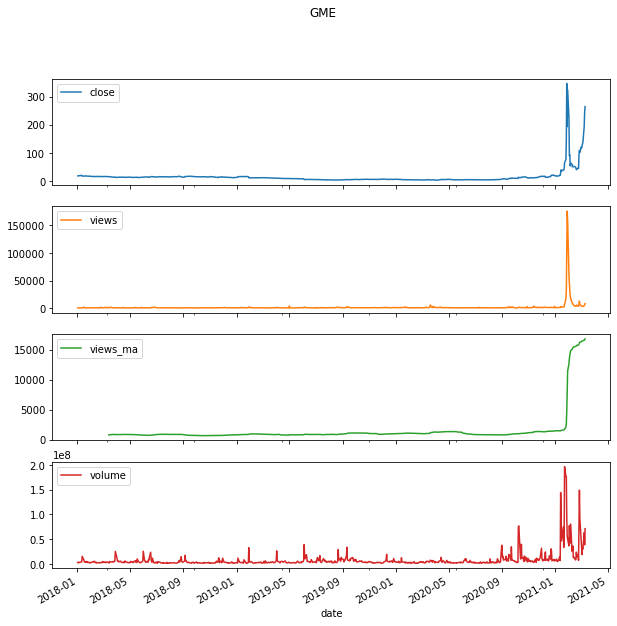

In [5]:
meme_stocks = ["GME"]
for stock in meme_stocks:
    wiki_ticker(stock)

### Look at how the views, views moving average and price relate with regrds to more stable stocks?
In this case we will loook at Microsoft and see how the PRice relates to the Wikipedia page number of Views and how the Views 50 day moving average.

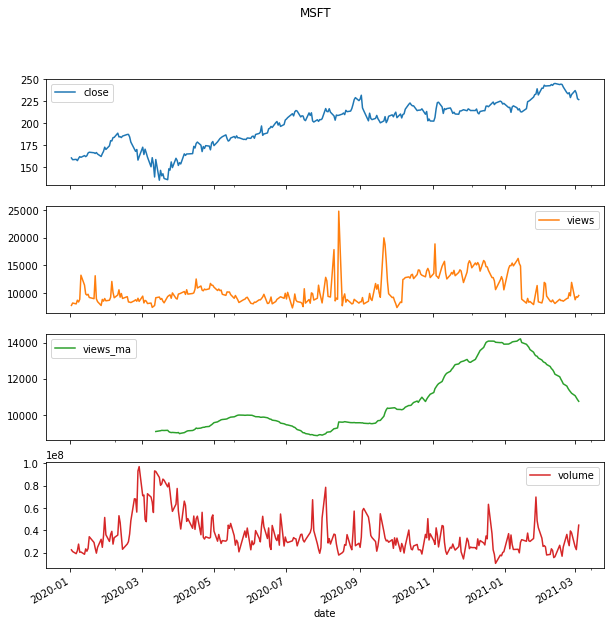

In [128]:
wiki_ticker("MSFT")

# Get the Top 50 Highest Viewed Pages and Check if the Stocks Moved by a large percent on those Days

In [153]:
query=f"""
SELECT * FROM (SELECT ticker_value AS ticker, idLabel_value AS article, R.date, R.views, Q.open, Q.close, Q.volume, Q.high, Q.low FROM `fidap-301014.fidapschema.wikidata_companies` AS L
LEFT JOIN
(SELECT article, date, views FROM `fidap-301014.fidapschema.wikidata_pages`) R
ON L.idLabel_value = R.article 
LEFT JOIN
(SELECT open, close, high, low, volume, ticker, date FROM `fidap-301014.fidapschema.daily`) Q
ON Q.ticker = L.ticker_value AND Q.date = R.date
ORDER BY R.date DESC) GROUP BY article, date, views, ticker, open, close, volume, high, low ORDER BY views DESC LIMIT 100
"""

In [154]:
top_data = fidap.sql(query)

In [155]:
top_data.dropna(inplace=True)

In [156]:
top_data.head()

,ticker,article,date,views,open,close,volume,high,low
0,GOOGL,Google,2019-03-27,773905,1191.92,1178.01,1471402.0,1191.92,1164.23
1,GOOG,Google,2019-03-27,773905,1185.50,1173.02,1400240.0,1187.56,1159.37
2,VOD,Vodacom,2020-02-04,491909,19.75,19.64,2927600.0,19.78,19.59
3,PFE,Pfizer,2020-11-09,302622,41.86,39.20,217880635.0,41.99,38.38
4,GOOGL,Google,2019-09-27,298207,1242.83,1225.95,1722481.0,1244.99,1215.20


In [160]:
top_data["price_swing_percentage"] = 100 * (top_data["high"] - top_data["low"])/top_data["open"]

In [164]:
top_data.sort_values(ascending=False, by=["price_swing_percentage"])

,ticker,article,date,views,open,close,volume,high,low,price_swing_percentage
14,GME,GameStop,2021-01-28,175970,265.00,193.60,56814826.0,483.00,112.25,139.905660
15,GME,GameStop,2021-01-29,158155,379.71,325.00,50397132.0,413.98,250.00,43.185589
30,GME,GameStop,2021-01-27,110598,354.83,347.51,91688446.0,380.00,249.00,36.919088
60,BNTX,BioNTech,2020-11-09,87684,114.02,104.80,14614871.0,115.00,98.51,14.462375
34,NET,Cloudflare,2020-12-10,104165,77.00,84.05,8564688.0,86.21,76.37,12.779221
...,...,...,...,...,...,...,...,...,...,...
56,GOOGL,Google,2019-12-17,90847,1362.41,1354.89,1648549.0,1364.33,1350.77,0.995295
70,GOOG,Alphabet Inc.,2019-12-05,83368,1328.00,1328.13,1212818.0,1329.36,1316.44,0.972892
2,VOD,Vodacom,2020-02-04,491909,19.75,19.64,2927600.0,19.78,19.59,0.962025
32,GOOG,Google,2019-12-18,110387,1356.60,1352.62,1657069.0,1360.47,1351.00,0.698069


## Can you make money by swing trading/day trading based off wikipedia page views?

In [175]:
day_trade_query = f"""
SELECT * FROM (SELECT ticker_value AS ticker, idLabel_value AS article, R.date, R.views, Q.open, Q.close, Q.volume, Q.high, Q.low FROM `fidap-301014.fidapschema.wikidata_companies` AS L
LEFT JOIN
(SELECT article, date, views FROM `fidap-301014.fidapschema.wikidata_pages`) R
ON L.idLabel_value = R.article 
LEFT JOIN
(SELECT open, close, high, low, volume, ticker, date FROM `fidap-301014.fidapschema.daily`) Q
ON Q.ticker = L.ticker_value AND Q.date = R.date
ORDER BY R.date DESC) WHERE ticker = 'GME' GROUP BY article, date, views, ticker, open, close, volume, high, low ORDER BY views DESC
"""

In [176]:
trade_data = fidap.sql(day_trade_query)
trade_data["price_swing_percentage"] = 100 * (trade_data["high"] - trade_data["low"])/trade_data["open"]

In [177]:
trade_data.set_index('date', inplace=True)
trade_data.sort_index(inplace=True)

In [178]:
trade_data.dropna(inplace=True)

In [179]:
trade_data

,ticker,article,views,open,close,volume,high,low,price_swing_percentage
date,,,,,,,,,
2018-01-02,GME,GameStop,684,17.96,18.26,2832725.0,18.29,17.78,2.839644
2018-01-03,GME,GameStop,691,18.29,18.20,3789189.0,18.37,17.92,2.460361
2018-01-04,GME,GameStop,661,18.20,18.32,2781341.0,18.38,17.96,2.307692
2018-01-05,GME,GameStop,622,18.38,18.68,3018989.0,18.73,18.22,2.774755
2018-01-08,GME,GameStop,702,18.80,19.23,3668401.0,19.40,18.80,3.191489
...,...,...,...,...,...,...,...,...,...
2021-03-02,GME,GameStop,4214,116.93,118.18,33627257.0,133.20,112.20,17.959463
2021-03-03,GME,GameStop,3463,122.51,124.18,19154603.0,127.75,113.12,11.941882
2021-03-04,GME,GameStop,3528,125.00,132.35,32458525.0,147.87,115.30,26.056000


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

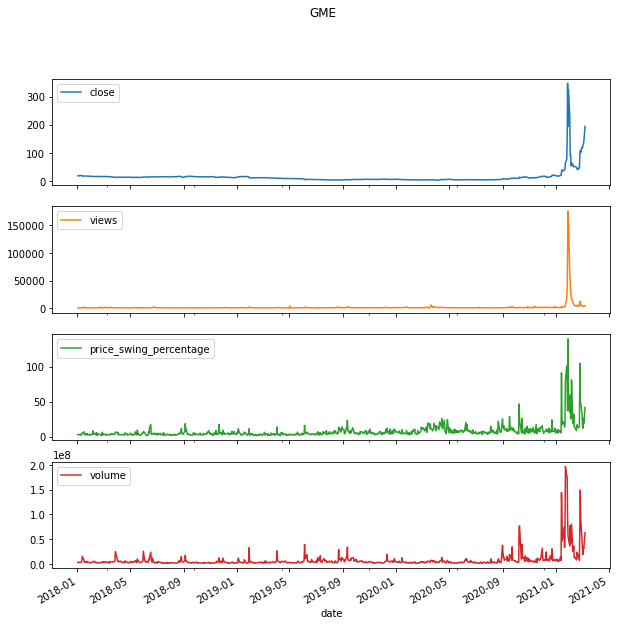

In [180]:
trade_data[['close','views', 'price_swing_percentage', 'volume']].plot.line(subplots=True, figsize=(10,10), title='GME')